## __0. Download dataset__
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [ ]:
# https://drive.google.com/file/d/1kc6XNqHZJg27KeBuoAoYj70_1rT92191/view?usp=sharing
# !gdown --id 1kc6XNqHZJg27KeBuoAoYj70_1rT92191

In [ ]:
# !unzip -q vqa_coco_dataset.zip

## __1. Import libraries and set random seed__

In [ ]:
# !pip install timm==0.8.17.dev0
# !pip install torchtext==0.15.1
# !pip install torchvision==0.16.0
# !pip install torchaudio==2.1.0
# !pip install torch==2.1.0
# !pip install transformers==4.27.1

In [4]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel, ViTImageProcessor
from transformers import AutoTokenizer, RobertaModel

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## __2. Read dataset__

In [6]:
train_data = []
train_set_path = 'vaq2.0.TrainImages.txt'

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        train_data.append(data_sample)

In [7]:
val_data = []
val_set_path = 'vaq2.0.DevImages.txt'

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        val_data.append(data_sample)

In [8]:
test_data = []
test_set_path = 'vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        test_data.append(data_sample)

In [9]:
classes = set([sample['answer'] for sample in train_data])
label2idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx2label = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx2label)

{0: 'no', 1: 'yes'}


## __3. Create Pytorch dataset__

In [10]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        label2idx,
        img_feature_extractor,
        text_tokenizer,
        device,
        transforms=None,
        img_dir='val2014-resised'
    ):
        self.data = data
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_feature_extractor = img_feature_extractor
        self.text_tokenizer = text_tokenizer
        self.device = device
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')
        if self.transforms:
            img = self.transforms(img)
        if self.img_feature_extractor:
            img = self.img_feature_extractor(images=img, return_tensors="pt")
            img = {k: v.to(self.device).squeeze(0) for k, v in img.items()}
        question = self.data[index]['question']
        if self.text_tokenizer:
            question = self.text_tokenizer(
                question,
                padding="max_length",
                max_length=20,
                truncation=True,
                return_tensors="pt"
            )
            question = {k: v.to(self.device).squeeze(0) for k, v in question.items()}
        label = self.data[index]['answer']
        label = torch.tensor(
            self.label2idx[label],
            dtype=torch.long
        ).to(self.device)
        sample = {
            'image': img,
            'question': question,
            'label': label
        }
        return sample

In [11]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.CenterCrop(size=180),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(3),
])

In [12]:
img_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = VQADataset(
    train_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device,
    transforms=data_transform
)
val_dataset = VQADataset(
    val_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)
test_dataset = VQADataset(
    test_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

c:\Users\tienn\anaconda3\envs\Kaggle31012\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tienn\.cache\huggingface\hub\models--google--vit-base-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\tienn\anaconda3\envs\Kaggle31012\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tienn\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [13]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

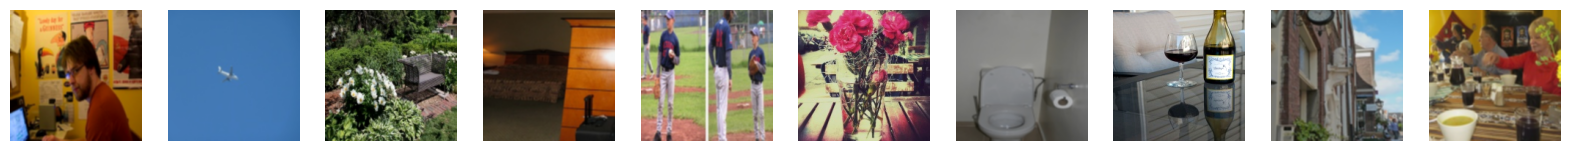

In [14]:
img_dir='val2014-resised/'
img_to_show = 10
shift = 10
test_imgs = [
    os.path.join(img_dir, sample['image_path']) for sample in train_data[shift:shift+img_to_show]
]
fig, axes = plt.subplots(nrows=1, ncols=img_to_show, figsize=(20, 4))
for ax, img_path in zip(axes, test_imgs):
    img_pil = Image.open(img_path).convert('RGB')
    preprocessed_img = data_transform(img_pil)
    ax.imshow(preprocessed_img)
    ax.axis('off')
plt.show()

## __4. Create VQA model__

In [15]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super(VisualEncoder, self).__init__()
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224")

    def forward(self, inputs):
        outputs = self.model(**inputs)
        return outputs.pooler_output

In [16]:
class TextEncoder(nn.Module):

    def __init__(self):
        super(TextEncoder, self).__init__()
        self.model = RobertaModel.from_pretrained("roberta-base")

    def forward(self, inputs):
        outputs = self.model(**inputs)
        return outputs.pooler_output

In [17]:
class Classifier(nn.Module):

    def __init__(self,
               hidden_size=512,
               dropout_prob=0.2,
               n_classes=2):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(768 * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [18]:
class VQAModel(nn.Module):

    def __init__(self,
               visual_encoder,
               text_encoder,
               classifier
               ):
        super(VQAModel, self).__init__()
        self.visual_encoder = visual_encoder
        self.text_encoder = text_encoder
        self.classifier = classifier

    def forward(self, image, answer):
        text_out = self.text_encoder(answer)
        image_out = self.visual_encoder(image)
        x = torch.cat((image_out, text_out), dim=1)
        x = self.classifier(x)
        return x

    def freeze(self, visual=True, textual=True, clas=False):
        if visual:
            for n,p in self.visual_encoder.named_parameters():
                p.requires_grad = False
        if textual:
            for n,p in self.text_encoder.named_parameters():
                p.requires_grad = False
        if clas:
            for n,p in self.classifier.named_parameters():
                p.requires_grad = False

In [19]:
n_classes = len(classes)
hidden_size = 256
dropout_prob = 0.2

text_encoder = TextEncoder().to(device)
visual_encoder = VisualEncoder().to(device)
classifier = Classifier(
    hidden_size=hidden_size,
    dropout_prob=dropout_prob,
    n_classes=n_classes
).to(device)

model = VQAModel(
    visual_encoder=visual_encoder,
    text_encoder=text_encoder,
    classifier=classifier
).to(device)
model.freeze()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
inputs = next(iter(train_loader))

model.eval()
with torch.no_grad():
    image = inputs['image']
    question = inputs['question']
    output = model(image, question)
    print(output.shape)

c:\Users\tienn\anaconda3\envs\Kaggle31012\lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


torch.Size([256, 2])


## __5. Training__

In [21]:
def evaluate(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for idx, inputs in enumerate(dataloader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [22]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, inputs in enumerate(train_loader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [23]:
lr = 1e-3
epochs = 50
scheduler_step_size = epochs * 0.8
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [24]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
)

EPOCH 1:	Train loss: 0.7029	Val loss: 0.6851	Val Acc: 0.5549324496558756
EPOCH 2:	Train loss: 0.6841	Val loss: 0.6764	Val Acc: 0.5741779250573541
EPOCH 3:	Train loss: 0.6749	Val loss: 0.6703	Val Acc: 0.5862860056079531
EPOCH 4:	Train loss: 0.6697	Val loss: 0.6658	Val Acc: 0.5972470048432322
EPOCH 5:	Train loss: 0.6616	Val loss: 0.6545	Val Acc: 0.6126688758603109
EPOCH 6:	Train loss: 0.6491	Val loss: 0.6467	Val Acc: 0.6186591893958705
EPOCH 7:	Train loss: 0.6394	Val loss: 0.6326	Val Acc: 0.637777211317869
EPOCH 8:	Train loss: 0.6207	Val loss: 0.6234	Val Acc: 0.6452969666071884
EPOCH 9:	Train loss: 0.6120	Val loss: 0.6142	Val Acc: 0.6588070354320673
EPOCH 10:	Train loss: 0.5863	Val loss: 0.6062	Val Acc: 0.6734641855722662
EPOCH 11:	Train loss: 0.5598	Val loss: 0.5692	Val Acc: 0.7060922763191435
EPOCH 12:	Train loss: 0.5363	Val loss: 0.5504	Val Acc: 0.7162885546775427
EPOCH 13:	Train loss: 0.5084	Val loss: 0.5467	Val Acc: 0.7180729033902625
EPOCH 14:	Train loss: 0.4878	Val loss: 0.5327	Va

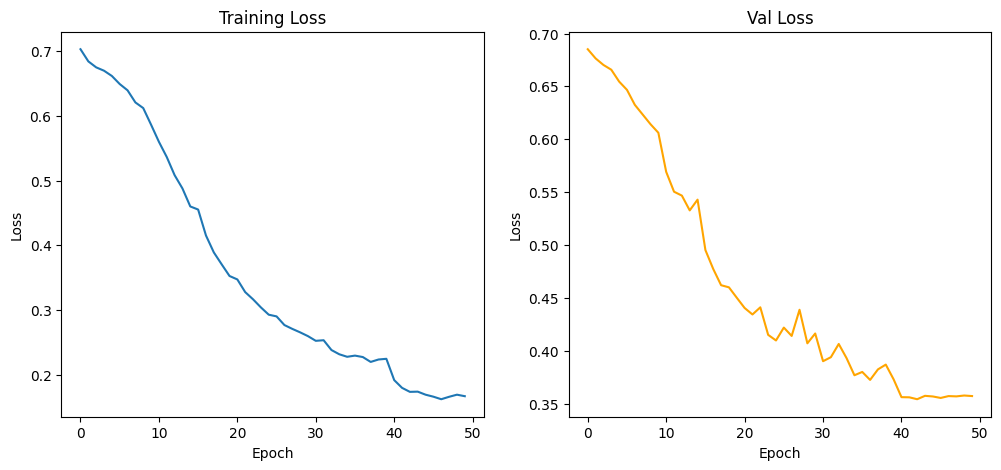

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## __6. Evaluation__

In [26]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.8418302319653327
Test accuracy:  0.6696340257171117


## __7. Inference__

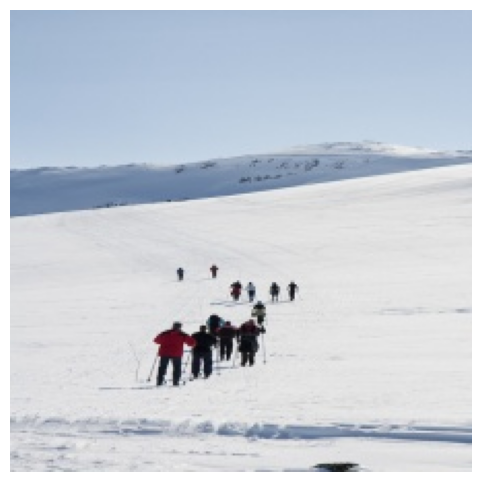

Question: Are there any trees visible ?
Groundtruth: no
Predicted: no


In [27]:
idx = 10
img_name = test_data[idx]['image_path']
img_path = os.path.join(img_dir, img_name)
question = test_data[idx]['question']
label = test_data[idx]['answer']

question_processed = text_tokenizer(
    question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_tensors="pt"
).to(device)


img = Image.open(img_path).convert("RGB")
img_processed = img_feature_extractor(images=img, return_tensors="pt").to(device)

model.eval()
with torch.no_grad():
    output = model(img_processed, question_processed)
    pred = torch.argmax(output, dim=1).item()

plt.figure(figsize=(6, 6))
plt.imshow(np.array(img))
plt.axis('off')
plt.show()

print(f'Question: {question}')
print(f'Groundtruth: {label}')
print(f'Predicted: {idx2label[pred]}')